# Guide Me Through the Q!

![Q](images/q.png)

## Abstract

Text

##  Table of Contents

* [Part 1: Creating the Data Set](#Part-1:-Creating-the-Data-Set)
    * [1.1 Concatenating the JSON Files](#1.1-Concatenating-the-JSON-Files)
    * [1.2 Producing the Dataframe](#1.2-Producing-the-Dataframe)
    * [1.3 Cleaning](#1.3-Cleaning)
    * [1.4 Adding an Indicator for Positive Reviews](#1.4-Adding-an-Indicator-for-Positive-Reviews)
* [Part 2: Numerical Analysis](#Part-2:-Numerical-Analysis)
    * [2.1 Statistics and Trends](#2.1-Statistics-and-Trends)
    * [2.2 Training and Testing](#2.2-Training-and-Testing)
        * [2.21 Linear SVM](#2.21-Linear-SVM)
* [Part 3: Text Analysis](#Part-3:-Text-Analysis)
* [References](#References)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Part 1: Creating the Data Set

### 1.1 Concatenating the JSON Files

The Q data we received consisted of about 2300 JSON files, each one representing a unique course's historical Q scores for each available semester. Out first task was to combine these individual JSON files into a single JSON Lines file; the JSON files were stored locally outside of the repository directory, and we used the `shututil` and `glob` libraries to concatenate these into `qall.jsonl`. Because the individual JSON files are local, we used the `os.path` library to check if the JSONL file already exists and to prevent the code from running if it does.

In [2]:
import shutil
import glob
import os.path

# Prevents code from running if the file already exists.
if not os.path.exists("qall.jsonl"):

    # Opens the JSONL file as output.
    with open("qall.jsonl", "wb") as outfile:
    
        # Iterates over the JSON files.
        for filename in glob.glob("../Q/*.json"):
        
            # Opens the current JSON file as input.
            with open(filename, "rb") as readfile:
            
                # Copies the JSON file to the JSONL file.
                shutil.copyfileobj(readfile, outfile)
            
                # Adds a new line as a delimiter.
                outfile.write("\n")

### 1.2 Producing the Dataframe

Each JSON file was structured using multiple nested dictionaries, with the following format:

* `scores`: a dictionary of mostly numerical data, separated by semester
    * `*semester*`: a dictionary of course and instructor scores
        * `course_score`: a dictionary of course info, ratings, and rating breakdowns
            * `overall`: a float of mean overall rating
            * `workload`: a float of mean workload rating
            * `difficulty`: a float of mean difficulty rating
            * `recommendation`: a float of mean recommendation rating
            * `enrollment`: an integer of class enrollment
            * `reponse rate`: a float of the proportion of students who reviewed the course
            * `QCourseOverall`: 
                * `number`: the string concatenation of department and course number, i.e. "COMPSCI 109"
                * `course_id`: an integer identifier for my.harvard.edu
                * `cat_num`: an integer indentifier for the Harvard Course Catalog
                * `1s`: an integer count of reviews with rating 1 for this category
                * `2s`: analagous, with 2s
                * `3s`: analagous, with 3s
                * `4s`: analagous, with 4s
                * `5s`: analagous, with 5s
            * `QDifficulty`: analagous to `QCourseOverall`, with difficulty ratings.
            * `QWorkload`: analagous to `QCourseOverall`, with workload ratings.
        * `instructor_scores`: a list of length 1 that contains a dictionary of instructor info and ratings
            * `number`: identical to that within `QCourseOverall`
            * `cat_num`: identical to that within `QCourseOverall`
            * `course_id`: identical to that within `QCourseOverall`
            * `year`: an int of the first of the two years represented in the given school year
            * `term`: an int with value 1 if the course took place in the Fall, 2 if Spring
            * `id`: a string indentifier of the professor
            * `first`: a string of the first name of the professor
            * `last`: a string of the last name
            * `InstructorOverall`: a float of mean overall instructor rating
            * `EffectiveLecturesorPresentations`: a float of mean lecture rating
            * `AccessibleOutsideClass`: a float of mean accessibility rating
            * `GeneratesEnthusiasm`: a float of mean enthusiasm rating
            * `FacilitatesDiscussionEncouragesParticipation`: a float of mean facilitation rating
            * `GivesUsefulFeedback`: a float of mean feedback rating
            * `ReturnsAssignmentsinTimelyFashion`: a float of mean timeliness rating
* `comments`: a dictionary of textual reviews, separated by semester into dictionaries
    * `*semester*`: a dictionary of comments for the given semester
        * `comments`: a list of strings that represent comments
* `mostRecentQ`: identical to the most recent semester data in `scores`
* `success`: indicates if the JSON was successfully retrieved

Any mean rating has range `1.0-5.0`, and response rate has a range `0.0-1.0`. The entries labeled `*semester*` can occur any number of times and have as a key the semester in which it took place (i.e. `Fall '12`).

We wanted our first dataframe `bigdf` to have a single row for each instance of a course (`COMPSCI 109` in `Fall '13` and `COMPSCI 109` in `Fall '14` have separate rows). This versatile dataframe could be adjusted in a number of different ways to suit the purposes of our data analysis. One caveat was a lack of course or instructor data, or both! To handle for this, we first created an empty dataframe with specified columns; then, we loaded the data for each cousrse using the `json` library, created a minimal dictionary for each semester, added further semester data to the dictionary conditional upon the data's existence, then appended that dictionary to the dataframe.

In [3]:
import json

# Creates the dataframe with columns specified.
bigdf = pd.DataFrame(columns=["C_Department","C_Number", "Course", "C_CatNum","C_ID","C_Semester","C_Year","C_Term",
                              "C_Overall","C_Workload","C_Difficulty","C_Recommendation","C_Enrollment","C_ResponseRate",
                              "I_First","I_Last","I_ID",
                              "I_Overall","I_EffectiveLectures","I_Accessible","I_GeneratesEnthusiasm",
                              "I_EncouragesParticipation","I_UsefulFeedback","I_ReturnsAssignmentsTimely",
                              "QOverall_1","QOverall_2","QOverall_3","QOverall_4","QOverall_5",
                              "QDifficulty_1","QDifficulty_2","QDifficulty_3","QDifficulty_4","QDifficulty_5",
                              "QWorkload_1","QWorkload_2","QWorkload_3","QWorkload_4","QWorkload_5",
                              "Comments"])

# Opens the JSONL file as the input.
with open("qall.jsonl") as data_file:

    # Iterates over each line.
    for line in data_file:

        # Loads the JSON.
        alldata = json.loads(line)

        # Iterates over each semester for the course.
        for semester in alldata["scores"]:

            # Retrieves the semester data.
            semdata = alldata["scores"][semester]

            # Retrieves the scores or comments if they exist, else None.
            cscores = semdata["course_score"] if "course_score" in semdata else None
            iscores = semdata["instructor_scores"][0] if "instructor_scores" in semdata else None
            comments = alldata["comments"][semester]["comments"] if semester in alldata["comments"] else None

            # Creates a dictionary that will be appended as a row to the dataframe.
            semdatadict = {"C_Semester": semester, "Comments": comments}

            # If the course scores exist...
            if cscores != None:
                
                # Retrieves the course name and separates it into department and number.
                course = str(cscores["QCourseOverall"]["number"]).split()
                if course[0] == "None":
                    course = [None, None]
                    fullname = "NODEPT-NOCOURSENUMBER"
                else:
                    fullname = course[0] + "-" + course[1]
                    
                # Updates the dictionary with the data.
                semdatadict.update({"C_Department": course[0],
                                    "C_Number": course[1],
                                    "Course": fullname,
                                    "C_CatNum": cscores["QCourseOverall"]["cat_num"],
                                    "C_ID": cscores["QCourseOverall"]["course_id"],
                                    "C_Overall": cscores["overall"],
                                    "C_Workload": cscores["workload"],
                                    "C_Difficulty": cscores["difficulty"],
                                    "C_Recommendation": cscores["recommendation"],
                                    "C_Enrollment": cscores["enrollment"],
                                    "C_ResponseRate": cscores["response rate"],
                                    "QOverall_1": cscores["QCourseOverall"]["1s"],
                                    "QOverall_2": cscores["QCourseOverall"]["2s"],
                                    "QOverall_3": cscores["QCourseOverall"]["3s"],
                                    "QOverall_4": cscores["QCourseOverall"]["4s"],
                                    "QOverall_5": cscores["QCourseOverall"]["5s"],
                                    "QDifficulty_1": cscores["QDifficulty"]["1s"],
                                    "QDifficulty_2": cscores["QDifficulty"]["2s"],
                                    "QDifficulty_3": cscores["QDifficulty"]["3s"],
                                    "QDifficulty_4": cscores["QDifficulty"]["4s"],
                                    "QDifficulty_5": cscores["QDifficulty"]["5s"],
                                    "QWorkload_1": cscores["QWorkload"]["1s"],
                                    "QWorkload_2": cscores["QWorkload"]["2s"],
                                    "QWorkload_3": cscores["QWorkload"]["3s"],
                                    "QWorkload_4": cscores["QWorkload"]["4s"],
                                    "QWorkload_5": cscores["QWorkload"]["5s"],})

            # If the instructor scores exist...
            if iscores != None:

                # Retrieves the course name and separates it into department and number.
                course = str(iscores["number"]).split()
                if course[0] == "None":
                    course = [None, None]
                    fullname = "NODEPT-NOCOURSENUMBER"
                else:
                    fullname = course[0] + "-" + course[1]

                # Updates the dictionary with the data.
                semdatadict.update({"C_Department": course[0],
                                    "C_Number": course[1],
                                    "Course": fullname,
                                    "C_CatNum": iscores["cat_num"],
                                    "C_ID": iscores["course_id"],
                                    "C_Year": iscores["year"],
                                    "C_Term": iscores["term"],
                                    "I_First": iscores["first"].strip(),
                                    "I_Last": iscores["last"].strip(),
                                    "I_ID": iscores["id"],
                                    "I_Overall": iscores["InstructorOverall"],
                                    "I_EffectiveLectures": iscores["EffectiveLecturesorPresentations"],
                                    "I_Accessible": iscores["AccessibleOutsideClass"],
                                    "I_GeneratesEnthusiasm": iscores["GeneratesEnthusiasm"],
                                    "I_EncouragesParticipation": iscores["FacilitatesDiscussionEncouragesParticipation"],
                                    "I_UsefulFeedback": iscores["GivesUsefulFeedback"],
                                    "I_ReturnsAssignmentsTimely": iscores["ReturnsAssignmentsinTimelyFashion"]})

            # Adds the dictionary as a row to the dataframe.
            bigdf = bigdf.append(semdatadict, ignore_index=True)

Here is a look at the resulting dataframe:

In [4]:
bigdf.head(5)

,C_Department,C_Number,Course,C_CatNum,C_ID,C_Semester,C_Year,C_Term,C_Overall,C_Workload,C_Difficulty,C_Recommendation,C_Enrollment,C_ResponseRate,I_First,I_Last,I_ID,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,QOverall_1,QOverall_2,QOverall_3,QOverall_4,QOverall_5,QDifficulty_1,QDifficulty_2,QDifficulty_3,QDifficulty_4,QDifficulty_5,QWorkload_1,QWorkload_2,QWorkload_3,QWorkload_4,QWorkload_5,Comments
0,HISTSCI,270,HISTSCI-270,58523,2697,Spring '12,2011,2,4.67,2.33,3.33,5.00,6,50.00,Rebecca,Lemov,79de794d3e2e19eb71a2033b0ec0b76d,4.67,4.33,4.00,4.33,5.00,4.50,4.00,0,0,0,1,2,0,0,2,1,0,0,2,1,0,0,[This course is a perfect example of what grea...
1,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '14,2014,1,4.10,7.10,None,3.50,13,76.92,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.50,4.60,3.70,3.90,3.90,4.10,4.60,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[The class has a fairly high work load, but Dr..."
2,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '13,2013,1,3.50,2.60,3.90,3.20,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.80,4.00,2.50,3.50,4.10,4.30,4.40,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[Philosophy of the State with Dr. Chen offers ...
3,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '12,2012,1,3.73,2.47,3.67,3.47,15,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.87,4.33,2.64,3.93,4.18,3.64,3.82,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[This was by far my favorite course. Dr. Chen ...
4,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '11,2011,1,3.85,2.00,3.54,3.62,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.08,3.75,3.31,3.92,4.46,4.23,4.08,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[Be prepared to read, Discussions were great, ..."


### 1.3 Cleaning

If the instructor data was missing for a course, `C_Year` and `C_Term` were left out. We iterated over each row to extract this information from `C_semester`:

In [5]:
# Iterates over each row in the dataframe
for index, row in bigdf.iterrows():

    # Retrieves the year.
    year = int(row["C_Semester"][-2:])

    # Based on semester, determines year and term.
    if row["C_Semester"][0:4] == "Fall":
        row["C_Term"] = 1
        row["C_Year"] = 2000 + year
    elif row["C_Semester"][0:6] == "Spring":
        row["C_Term"] = 2
        row["C_Year"] = 1999 + year
    else:
        continue

We decided to delete course that has no department or number. Although there is textual data in the comments, the missing number is a result of having no course and instructor scores, so there is little we can do with it numerically:

In [6]:
bigdf = bigdf[bigdf["C_Department"]==bigdf["C_Department"]]
bigdf = bigdf[bigdf["C_Department"]!=None]

Then, we adjusted the types of each column to prepare for data analysis. We created a dictionary `coltypes` with keys as types and values as a list of the columns that should be those types. All columns except `Comments` were categorized as either an `int`, a `float`, or a `string`:

In [7]:
coltypes = {int: ["C_CatNum","C_ID","C_Year","C_Term","C_Enrollment",
                  "QOverall_1","QOverall_2","QOverall_3","QOverall_4","QOverall_5",
                  "QDifficulty_1","QDifficulty_2","QDifficulty_3","QDifficulty_4","QDifficulty_5",
                  "QWorkload_1","QWorkload_2","QWorkload_3","QWorkload_4","QWorkload_5"],
            float: ["C_Overall","C_Workload","C_Difficulty","C_Recommendation","C_ResponseRate",
                    "I_Overall","I_EffectiveLectures","I_Accessible","I_GeneratesEnthusiasm",
                    "I_EncouragesParticipation","I_UsefulFeedback","I_ReturnsAssignmentsTimely",
                    "QOverall_1","QOverall_2","QOverall_3","QOverall_4","QOverall_5"],
            str: ["C_Number","C_Department","C_Semester","I_First","I_Last","I_ID"]}

Some of the `string` cells contained unicode that could not be written to a csv. Using the `unidecode` library, we converted these to writable strings:

In [8]:
from unidecode import unidecode

for index, row in bigdf.iterrows():
    for strcol in coltypes[str]:
        try:
            str(row[strcol])
        except UnicodeEncodeError:
            bigdf.loc[index, row[row.values==row[strcol]].index[0]] = unidecode(row[strcol])

Then, we replaced `None` values with `NaN` for floats and `-1` for ints.

In [9]:
for intcol in coltypes[int]:
    bigdf = bigdf.replace({intcol: {None: -1, "": -1}})

for floatcol in coltypes[float]:
    bigdf = bigdf.replace({floatcol: {None: np.nan}})

To finish correcting the types, we cast the entire columns as the desired type using the keys in `coltypes`:

In [10]:
for ctp in coltypes:
    for col in coltypes[ctp]:
        bigdf[col] = bigdf[col].astype(ctp)

### 1.4 Adding an Indicator for Positive Reviews

In order to provide some useful insight on what makes a good class, we had to determine how to classify courses as positive or negative. Ultimately, we decided that the threshold should be the median of overall q scores in the given semester, so that half of the courses would be good and half would be bad. We grouped by semester in order to reduce the effect of semester-specific events that could possibly shift that semester's scores.

In [11]:
# Adds an empty series for the semester median to the dataframe.
bigdf["Sem_Median"] = pd.Series(index=bigdf.index)

# Iterates over each semester, adding the semester median to the series.
for name, group in bigdf.groupby(["C_Year", "C_Term"]):
    bigdf.loc[(bigdf["C_Year"]==name[0])&(bigdf["C_Term"]==name[1]), "Sem_Median"] = np.nanmedian(group["C_Overall"].values)

# Determines whether or not a review is positive by comparing the Q score to the semester median.
bigdf["Positive"] = pd.Series(bigdf["C_Overall"]>=bigdf["Sem_Median"], index=bigdf.index)

Here is a look at the final data set:

In [12]:
bigdf.head(5)

,C_Department,C_Number,Course,C_CatNum,C_ID,C_Semester,C_Year,C_Term,C_Overall,C_Workload,C_Difficulty,C_Recommendation,C_Enrollment,C_ResponseRate,I_First,I_Last,I_ID,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,QOverall_1,QOverall_2,QOverall_3,QOverall_4,QOverall_5,QDifficulty_1,QDifficulty_2,QDifficulty_3,QDifficulty_4,QDifficulty_5,QWorkload_1,QWorkload_2,QWorkload_3,QWorkload_4,QWorkload_5,Comments,Sem_Median,Positive
0,HISTSCI,270,HISTSCI-270,58523,2697,Spring '12,2011,2,4.67,2.33,3.33,5.00,6,50.00,Rebecca,Lemov,79de794d3e2e19eb71a2033b0ec0b76d,4.67,4.33,4.00,4.33,5.00,4.50,4.00,0,0,0,1,2,0,0,2,1,0,0,2,1,0,0,[This course is a perfect example of what grea...,4.30,True
1,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '14,2014,1,4.10,7.10,NaN,3.50,13,76.92,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.50,4.60,3.70,3.90,3.90,4.10,4.60,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[The class has a fairly high work load, but Dr...",4.30,False
2,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '13,2013,1,3.50,2.60,3.90,3.20,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.80,4.00,2.50,3.50,4.10,4.30,4.40,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[Philosophy of the State with Dr. Chen offers ...,4.30,False
3,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '12,2012,1,3.73,2.47,3.67,3.47,15,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.87,4.33,2.64,3.93,4.18,3.64,3.82,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[This was by far my favorite course. Dr. Chen ...,4.25,False
4,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '11,2011,1,3.85,2.00,3.54,3.62,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.08,3.75,3.31,3.92,4.46,4.23,4.08,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[Be prepared to read, Discussions were great, ...",4.20,False


Now, we write this to a csv file for safekeeping.

In [13]:
bigdf.to_csv("bigdf.csv", index=False)

## Part 2: Numerical Analysis

### 2.1 Statistics and Trends

First, we plotted the distribution of overall course scores by semester as a part of our exploratory analysis. We can observe that there is a high density around the `4-5` range, with a mean of `4.18` and a median of `4.25`, indicating that the histogram is skewed left.

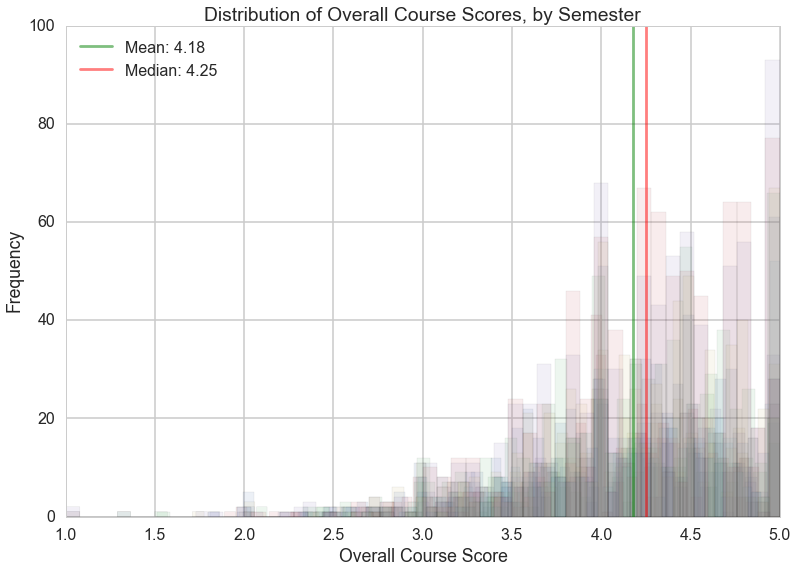

In [41]:
plt.plot();

# Plots a histogram of each semester's overall course scores.
for name, group in bigdf.groupby(["C_Year", "C_Term"]):
    group["C_Overall"].hist(bins=50, alpha=0.1);

# Calculates the mean and median.
mean = bigdf["C_Overall"].mean()
median = bigdf["C_Overall"].median()

# Adds the mean and median to the histogram, with a legend.
plt.axvline(mean, color="green", label="Mean: %0.2f" % mean, alpha=0.5);
plt.axvline(median, color ="red", label="Median: %0.2f" % median, alpha=0.5);
plt.legend(loc="upper left");

# Formats the plot.
plt.xlim(1,5);
plt.xlabel("Overall Course Score");
plt.ylabel("Frequency");
plt.title("Distribution of Overall Course Scores, by Semester");

We can take a look at the highest and lowest rated classes.

using `groupby`. The CHEMBIO department has the lowest average course scores at about `3.12`, and the PLSH, MEDGREEK, PAL, and GIKUYU departments have had perfect scores for each course in Q guide history. The perfect scores are likely due to low enrollment and people who self-select into those course offerings, whereas the low scores are coming from difficult science departments that could offering requirements for the premed track or other rigorous curricula.

In [42]:
#ASDF

We can take a look at the highest rated departments and the lowest, using `groupby`. The CHEMBIO department has the lowest average course scores at about `3.12`, and the PLSH, MEDGREEK, PAL, and GIKUYU departments have had perfect scores for each course in Q guide history. The perfect scores are likely due to low enrollment and people who self-select into those course offerings, whereas the low scores are coming from difficult science departments that could offering requirements for the premed track or other rigorous curricula.

In [43]:
# Creates a series of department mean overall course scores.
deprank = bigdf.groupby("C_Department")["C_Overall"].mean()

# Prints the top 5 and bottom 5 departments.
deprank.sort(ascending=False)
print "TOP 5 DEPARTMENTS:\n", deprank.head(5), "\n"
deprank.sort(ascending=True)
print "BOTTOM 5 DEPARTMENTS:\n", deprank.head(5)

TOP 5 DEPARTMENTS:
C_Department
PLSH        5.000000
MEDGREEK    5.000000
PAL         5.000000
GIKUYU      5.000000
ROM-LANG    4.966667
Name: C_Overall, dtype: float64 

BOTTOM 5 DEPARTMENTS:
C_Department
CHEMBIO       3.116667
BCMP          3.446429
APPHY         3.577692
SCI-PHYUNV    3.585806
APMTH         3.653625
Name: C_Overall, dtype: float64


Another interesting trend is the slight discrepancy between Fall scores and Spring scores. In the entire history of the Q, Fall score means have been consistently lower than those in the Spring. However, both have risen over time.

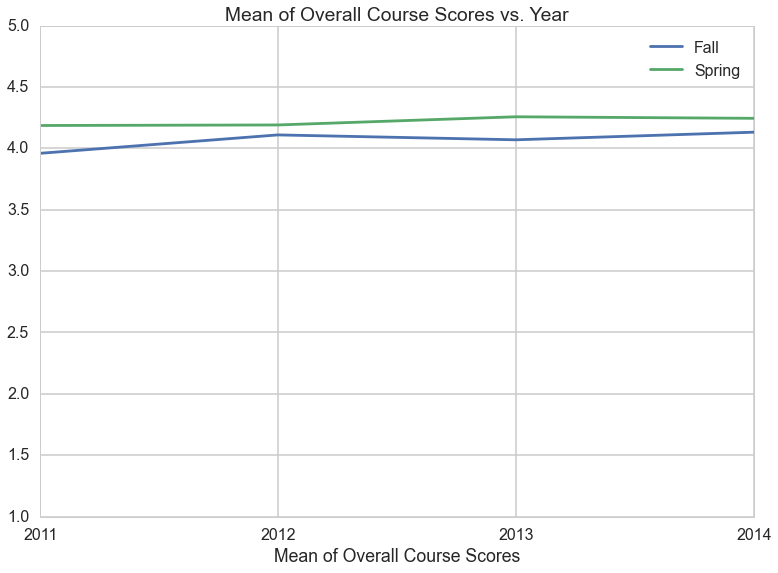

In [44]:
# Creates a series of semester mean overall course scores.
semrank = bigdf.groupby("C_Semester")["C_Overall"].mean()

# Plots by semester.
semrank[0:4].plot(label="Fall")
semrank[5:9].plot(label="Spring")

# Formats and labels the plot.
plt.xticks(range(4),['2011','2012','2013','2014']);
plt.ylim(1,5)
plt.xlabel("Year")
plt.xlabel("Mean of Overall Course Scores")
plt.title("Mean of Overall Course Scores vs. Year")
plt.legend();

### 2.2 Training and Testing

In order to figure out which numerical data are most responsible for the overall course score, we created a copy of the dataframe specifically for numerical analysis, then removed certain columns that we should avoid running regressions on, such as the breakdown of ratings (how many 1s, 2s, etc.), the textual reviews, any string fields, and the course catalog number and id; for the sake of easily identifying courses, we kept department, number, and semester. We removed all reviews from `Fall '14`, as the format of the Q guide changed that semester. Finally, we dropped all rows with missing data.

In [45]:
# Copies the big dataframe.
numdf = bigdf.copy()

# Drops columns that we will not be needing.
numdf = numdf.drop(numdf.columns[[2,3,4,6,7,11]+list(range(13,17))+list(range(24,40))], axis=1)

# Removes Fall '14 data.
numdf = numdf[numdf["C_Semester"] != "Fall '14"]

# Drops rows with missing data.
numdf = numdf.dropna(how="any")

Here is the resulting dataframe for our numerical analysis:

In [46]:
numdf.head(5)

,C_Department,C_Number,C_Semester,C_Overall,C_Workload,C_Difficulty,C_Enrollment,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,Sem_Median,Positive
0,HISTSCI,270,Spring '12,4.67,2.33,3.33,6,4.67,4.33,4.00,4.33,5.00,4.50,4.00,4.30,True
2,EXPOS,20.132,Fall '13,3.50,2.60,3.90,13,3.80,4.00,2.50,3.50,4.10,4.30,4.40,4.30,False
3,EXPOS,20.132,Fall '12,3.73,2.47,3.67,15,3.87,4.33,2.64,3.93,4.18,3.64,3.82,4.25,False
4,EXPOS,20.132,Fall '11,3.85,2.00,3.54,13,4.08,3.75,3.31,3.92,4.46,4.23,4.08,4.20,False
5,EXPOS,20.133,Spring '13,4.42,2.58,3.50,12,4.67,4.50,4.08,4.42,4.70,4.60,4.30,4.29,True


Next, we split the data into training and test sets. Since we are trying to use previous Q data to predict next semester's, we tested on `Spring '14` data and trained on the data in previous semesters.

In [47]:
# Separates Spring '14 into the test set and the rest into the training set.
train = numdf[numdf["C_Semester"] != "Spring '14"]
test = numdf[numdf["C_Semester"] == "Spring '14"]

# Prints the size of the sets.
print "Length of Train is:", len(train)
print "Length of Test is: ", len(test)

Length of Train is: 4953
Length of Test is:  604


Because we included non-numerical columns in the dataframe, we created a list `lcols` to specify which columns should be used for training.

In [48]:
# Creates a list of all the columns we have in the numerical dataframe.
lcols = list(train.columns)

# Removes columns we do not need for training.
for c in ["C_Department","C_Number","C_Semester","C_Overall","Sem_Median","Positive"]:
    lcols.remove(c)

# Shows the remaining columns.
lcols

['C_Workload',
 'C_Difficulty',
 'C_Enrollment',
 'I_Overall',
 'I_EffectiveLectures',
 'I_Accessible',
 'I_GeneratesEnthusiasm',
 'I_EncouragesParticipation',
 'I_UsefulFeedback',
 'I_ReturnsAssignmentsTimely']

Now, we will separate the response variable, `Positive`, from the data in `lcols`.

In [49]:
# Creates the X matrix.
Xtrain = train[lcols].values
Xtest = test[lcols].values

# Creates the y response vector.
ytrain = train["Positive"].values
ytest = test["Positive"].values

#### 2.21 Linear SVM

As in homework 3, we will start off with a Linear SVM because of its quickness, running `GridSearchCV` over a range of regularization coefficients with 5-fold cross validation.

In [50]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV

# Creates a Linear SVM to be trained.
clfsvm = LinearSVC(loss="hinge")

# Creates a list of regularization coefficients to be used.
Cs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Performs a grid serach on the Linear SVM
gs = GridSearchCV(clfsvm, param_grid={'C':Cs}, cv=5)
gs.fit(Xtrain, ytrain)

# Prints the best C value and its accuracy.
print "The best value of C is: %0.3f" % gs.best_params_["C"]
print "The accuracy is:        %0.4f" % gs.best_score_

The best value of C is: 1.000
The accuracy is:        0.8373


Now, we will refit the data again using the best classifier given by the grid search.

In [51]:
# Stores the best classifier.
best = gs.best_estimator_

# Refits the training data.
best.fit(Xtrain, ytrain)

# Prints the refitted accuracy.
print "Refitting the training data with C = %0.3f:" % gs.best_params_["C"]
print "Training accuracy is: %0.4f" % best.score(Xtrain, ytrain)
print "Test accuracy is:     %0.4f" % best.score(Xtest, ytest)

Refitting the training data with C = 1.000:
Training accuracy is: 0.7737
Test accuracy is:     0.7632


#### 2.22 Logistic Regression

Now, we will move onto a logistic regression.

In [52]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression()
logisticmodel = model.fit(Xtrain, ytrain)

# Prints the accuracies on both sets.
print "Training accuracy is:", model.score(Xtrain, ytrain) 
print "Test accuracy is:    ", model.score(Xtest, ytest)

Training accuracy is: 0.85523924894
Test accuracy is:     0.854304635762


In [53]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn import ensemble

rf = RandomForestClassifier(n_estimators=100)
rfmodel = rf.fit(Xtrain, ytrain) 

In [54]:
acc = rfmodel.score(Xtest,ytest) 
acc

0.86092715231788075

In [55]:
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):

    initial = False

    if not ax:
        ax = plt.gca()
        initial=True

    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds = roc_curve(ytest, clf.decision_function(xtest))

    roc_auc = auc(fpr, tpr)

    if skip:
        l = fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))

    label_kwargs = {}
    label_kwargs['bbox'] = dict(boxstyle='round,pad=0.3', alpha=0.2)

    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)

    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')

    ax.legend(loc="lower right")

    return ax

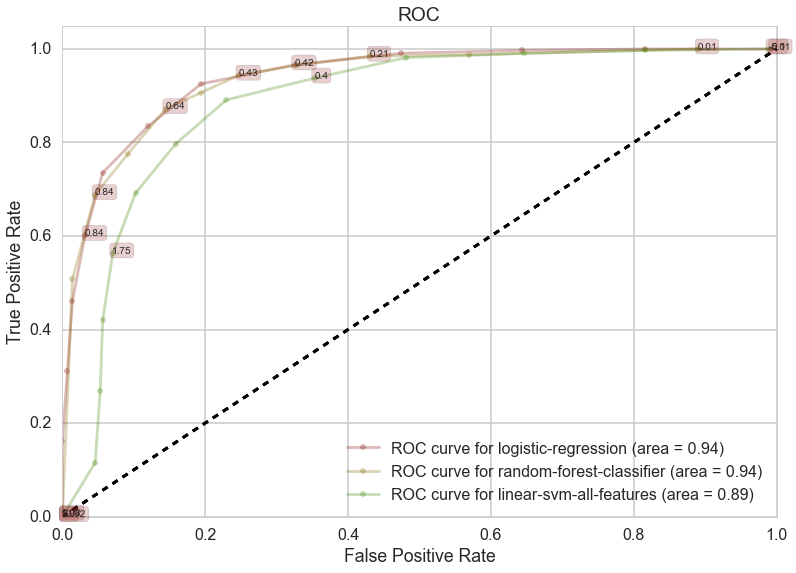

In [56]:
with sns.hls_palette(8, l=.3, s=.8):
    ax = make_roc("logistic-regression", model, ytest, Xtest, labe=200, skip=50) 
    ax = make_roc("random-forest-classifier", rfmodel, ytest, Xtest, labe=20, skip=10) 
    ax = make_roc("linear-svm-all-features", best, ytest, Xtest, labe=200, proba=False, skip=50)   

In [57]:
def nonzero_lasso(clf):
    featuremask = (clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False) 

lasso_importances = nonzero_lasso(best)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.reset_index("feature", inplace=True)
lasso_importances

,feature,abscoef,coef
0,I_Overall,2.075871,2.075871
1,I_GeneratesEnthusiasm,0.573253,0.573253
2,C_Difficulty,0.407715,-0.407715
3,I_EffectiveLectures,0.399844,0.399844
4,C_Workload,0.324239,0.324239
5,I_Accessible,0.270809,-0.270809
6,I_EncouragesParticipation,0.232546,0.232546
7,I_ReturnsAssignmentsTimely,0.130053,0.130053
8,C_Enrollment,0.017747,0.017747
9,I_UsefulFeedback,0.014422,0.014422


In [58]:
#Let's run a pipelined classifier with feature selection to see if we can improve our classifier.  
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr

def pearson_scorer(X,y):
    rs = np.zeros(X.shape[1])
    pvals = np.zeros(X.shape[1])
    i = 0
    for v in X.T:
        rs[i], pvals[i] = pearsonr(v, y)
        i = i + 1
    return np.abs(rs), pvals

selectorlinearsvm = SelectKBest(k=10, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [59]:
# Now we can see if our pipeline linear SVM classifier with feature select did better than our original linear SVM classifier.
pipeline = pipelinearsvm.fit(Xtrain, ytrain) 
pipeline.score(Xtest, ytest) 

0.86258278145695366

In [60]:
#What features did the pipeline classifier select? 
np.array(lcols)[pipeline.get_params()["select"].get_support()]

array(['C_Workload', 'C_Difficulty', 'C_Enrollment', 'I_Overall',
       'I_EffectiveLectures', 'I_Accessible', 'I_GeneratesEnthusiasm',
       'I_EncouragesParticipation', 'I_UsefulFeedback',
       'I_ReturnsAssignmentsTimely'], 
      dtype='|S26')

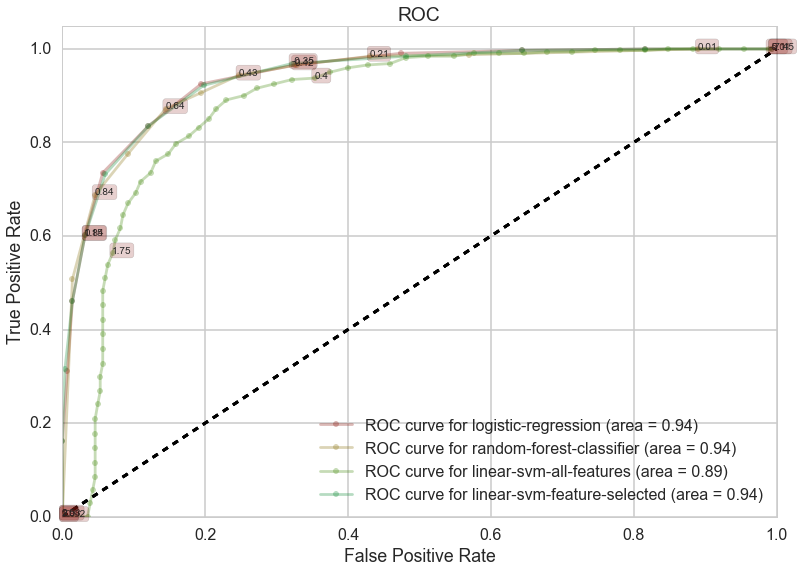

In [61]:
with sns.hls_palette(8, l=.3, s=.8):
    ax = make_roc("logistic-regression",model, ytest, Xtest, labe=200, skip=50) 
    ax = make_roc("random-forest-classifier", rfmodel, ytest, Xtest, labe=20, skip=10) 
    ax = make_roc("linear-svm-all-features", best, ytest, Xtest, labe=200, proba=False, skip=10)   
    ax = make_roc("linear-svm-feature-selected", pipeline, ytest, Xtest, labe=200, proba=False, skip=50)

## Part 3: Text Analysis

A critical part of any review are the comments. We will now proceed to analyze the comments in our q data. We will judge the predictive power of these comments, and analyze the role they play in a score's q rating.

In [14]:
import os
import math
from itertools import chain
import ast

The "unit" that we are looking at is the course-semester. In the previous notebook, for each course-semester, we had all comments, all associated Q values, and an attribute 'Positive' which is true if the average Q score for that course for that semester is greater than or equal to the average Q score across all courses for that semester. The 'Positive' attribute is false otherwise. In other words, a course-semester is defined to have an overall positive rating (Positive = True) if its Q score is above the average Q score across all courses for that semester.

We begin by loading in our complete dataframe of comments, which was stored in a csv from the last Python notebook. We will randomly subsample 10 comments per course-semester and only consider course-semesters with 10 or more comments. Our subsampled dataframe will consist of 5 columns: Course, C_Semester, Positive, C_Overall, and Sampled_Comments.

In [15]:
MIN_PER_COURSESEM_REVIEWS = 10

In [16]:
bigdf=pd.read_csv("bigdf.csv")
bigdf.reset_index(drop=True)
bigdf.head(5)

,C_Department,C_Number,Course,C_CatNum,C_ID,C_Semester,C_Year,C_Term,C_Overall,C_Workload,C_Difficulty,C_Recommendation,C_Enrollment,C_ResponseRate,I_First,I_Last,I_ID,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,QOverall_1,QOverall_2,QOverall_3,QOverall_4,QOverall_5,QDifficulty_1,QDifficulty_2,QDifficulty_3,QDifficulty_4,QDifficulty_5,QWorkload_1,QWorkload_2,QWorkload_3,QWorkload_4,QWorkload_5,Comments,Sem_Median,Positive
0,HISTSCI,270,HISTSCI-270,58523,2697,Spring '12,2011,2,4.67,2.33,3.33,5.00,6,50.00,Rebecca,Lemov,79de794d3e2e19eb71a2033b0ec0b76d,4.67,4.33,4.00,4.33,5.00,4.50,4.00,0,0,0,1,2,0,0,2,1,0,0,2,1,0,0,[u'This course is a perfect example of what gr...,4.30,True
1,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '14,2014,1,4.10,7.10,NaN,3.50,13,76.92,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.50,4.60,3.70,3.90,3.90,4.10,4.60,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[u'The class has a fairly high work load, but ...",4.30,False
2,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '13,2013,1,3.50,2.60,3.90,3.20,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.80,4.00,2.50,3.50,4.10,4.30,4.40,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[u'Philosophy of the State with Dr. Chen offer...,4.30,False
3,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '12,2012,1,3.73,2.47,3.67,3.47,15,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.87,4.33,2.64,3.93,4.18,3.64,3.82,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[u'This was by far my favorite course. Dr. Che...,4.25,False
4,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '11,2011,1,3.85,2.00,3.54,3.62,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.08,3.75,3.31,3.92,4.46,4.23,4.08,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[u'Be prepared to read', u'Discussions were gr...",4.20,False


We write a helper function sample_comments that takes in a list of comments in string form and then returns one string that contains MIN_PER_COURSEM_REVIEWS randomly selected comments concatenated together.

In [17]:
def sample_comments(commentsListAsString):
    if type(commentsListAsString) != str:
        return ""
    else:
        allComments = ast.literal_eval(commentsListAsString)
        if len(allComments) >= MIN_PER_COURSESEM_REVIEWS:
            return " ".join(np.random.choice(allComments, MIN_PER_COURSESEM_REVIEWS, replace=False))
        else:
            return ""

subdf = bigdf[["Course","C_Semester","Comments","Positive","C_Overall"]].dropna()
subdf["Sampled_Comments"] = subdf.Comments.map(sample_comments)
subdf = subdf[subdf.Sampled_Comments != ""]
subdf["Course_Semester"] = subdf.Course + "-" + subdf.C_Semester
subdf = subdf[["Course","C_Semester","Course_Semester","Positive","C_Overall","Sampled_Comments"]]

Here is a look at the textual dataframe:

In [18]:
subdf.head(5)

,Course,C_Semester,Course_Semester,Positive,C_Overall,Sampled_Comments
2,EXPOS-20.132,Fall '13,EXPOS-20.132-Fall '13,False,3.50,I would inform them that this class demands ma...
3,EXPOS-20.132,Fall '12,EXPOS-20.132-Fall '12,False,3.73,This was by far my favorite course. Dr. Chen i...
13,EXPOS-20.131,Fall '14,EXPOS-20.131-Fall '14,False,3.80,"- perhaps a bit intimidating, this is an enjoy..."
14,EXPOS-20.131,Fall '13,EXPOS-20.131-Fall '13,False,3.60,Do not take this course. The readings are long...
16,EXPOS-20.131,Fall '11,EXPOS-20.131-Fall '11,True,4.50,If you are interested in political philosophy ...


Now we will convert our comments dataframe, subdf, to a spark dataframe for text analysis

In [19]:
#setup spark
import os
import findspark
import pyspark
from pyspark.sql import SQLContext

findspark.init()
print findspark.find()

conf = (pyspark.SparkConf()
        .setMaster('local')
        .setAppName('pyspark')
        .set("spark.executor.memory", "2g"))
sc = pyspark.SparkContext(conf=conf)
import sys
rdd = sc.parallelize(xrange(10), 10)
rdd.map(lambda x: sys.version).collect()
sys.version

sqlsc = SQLContext(sc)

/usr/local/opt/apache-spark/libexec


In [20]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text
import re

punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
stopwords = text.ENGLISH_STOP_WORDS

regex1 = re.compile(r"\.{2,}")
regex2 = re.compile(r"\-{2,}")

#Useless verbs courtesy of: http://mbweston.com/2012/11/26/writing-editing-find-and-eliminate-useless-verbs/
uselessverbs = ['be','is','are','be','was','were','been','being',
                'go','goes','went','gone','going','put','puts','putting',
                'do','does','did','done','doing',
                'come','comes','came','coming',
                'have','have','has','had','having',
                'can','could','begin','begins','began','begun','beginning',
                'seem','seems','seemed','seeming',
                'get','got','gotten','getting',
                'become','became','becoming']

We write a get parts function to parse the language in the comments. This customized get_parts function returns lists of the nouns, adjectives and verbs in the comments.

In [21]:
def get_parts(thetext):
    thetext = re.sub(regex1, ' ', thetext)
    thetext = re.sub(regex2, ' ', thetext)
    nouns = []
    descriptives = []
    verbs = []
    for i, sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        verbs.append([])
        for token in sentence:
            #print token
            if len(token[4]) > 0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4]) == 1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4]) == 1:
                        continue
                    nouns[i].append(token[4])
                elif token[1] in ['VB','VBP','VBZ','VBG','VBD','VBN']:
                    if token[4] in stopwords or token[4] in uselessverbs or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4]) == 1:
                        continue
                    verbs[i].append(token[4])
    out = zip(nouns, descriptives, verbs)
    nouns2 = []
    descriptives2 = []
    verbs2 = []
    for n, d, v in out:
        if len(n) != 0 and len(d) ! =0 and len(v) != 0:
            nouns2.append(n)
            descriptives2.append(d)
            verbs2.append(v)
    return nouns2, descriptives2, verbs2

In [22]:
subdf = sqlsc.createDataFrame(subdf)
subdf.show(5)

+------------+----------+--------------------+--------+---------+--------------------+
|      Course|C_Semester|     Course_Semester|Positive|C_Overall|    Sampled_Comments|
+------------+----------+--------------------+--------+---------+--------------------+
|EXPOS-20.132|  Fall '13|EXPOS-20.132-Fall...|   false|      3.5|I would inform th...|
|EXPOS-20.132|  Fall '12|EXPOS-20.132-Fall...|   false|     3.73|This was by far m...|
|EXPOS-20.131|  Fall '14|EXPOS-20.131-Fall...|   false|      3.8|- perhaps a bit i...|
|EXPOS-20.131|  Fall '13|EXPOS-20.131-Fall...|   false|      3.6|Do not take this ...|
|EXPOS-20.131|  Fall '11|EXPOS-20.131-Fall...|    true|      4.5|If you are intere...|
+------------+----------+--------------------+--------+---------+--------------------+
only showing top 5 rows



We collect the parts of speech (nouns, adjectives, and verbs) for our randomly selected comments.

In [23]:
comment_parts = subdf.rdd.map(lambda r: get_parts(r.Sampled_Comments))
comment_parts.take(1)

[([[u'philosophy',
    u'state',
    u'discussion',
    u'struggle',
    u'balance',
    u'nature',
    u'society',
    u'course'],
   [u'page',
    u'reading',
    u'day',
    u'syllabus',
    u'warning',
    u'thing',
    u'tardiness',
    u'grade'],
   [u'course'],
   [u'reading', u'understanding', u'work'],
   [u'class', u'lot'],
   [u'class', u'improvement', u'writing', u'understanding', u'writing'],
   [u'class'],
   [u'lot', u'philosophy', u'professor', u'lot'],
   [u'course', u'lot', u'reading', u'writing'],
   [u'philosophy', u'state', u'class', u'writing', u'essay', u'college'],
   [u'matter', u'society'],
   [u'page', u'entirety', u'work'],
   [u'class', u'material', u'experience'],
   [u'student', u'class', u'philosophy', u'level', u'discussion'],
   [u'class', u'philosophy', u'introduction', u'course', u'ton', u'student'],
   [u'class', u'discussion', u'class', u'lot', u'philosophy'],
   [u'state',
    u'philosophy',
    u'course',
    u'philosophy',
    u'stimulating',
  

In [24]:
parsedcomments = comment_parts.collect()

We begin our text analysis with an LDA of the nouns in the comments.

The list of lists of nouns for the first course-semester represented in parsedcomments is shown below. Each individual list of nouns represents the nouns of a sentence.

In [25]:
[e[0] for e in parsedcomments[:1]]

[[[u'philosophy',
   u'state',
   u'discussion',
   u'struggle',
   u'balance',
   u'nature',
   u'society',
   u'course'],
  [u'page',
   u'reading',
   u'day',
   u'syllabus',
   u'warning',
   u'thing',
   u'tardiness',
   u'grade'],
  [u'course'],
  [u'reading', u'understanding', u'work'],
  [u'class', u'lot'],
  [u'class', u'improvement', u'writing', u'understanding', u'writing'],
  [u'class'],
  [u'lot', u'philosophy', u'professor', u'lot'],
  [u'course', u'lot', u'reading', u'writing'],
  [u'philosophy', u'state', u'class', u'writing', u'essay', u'college'],
  [u'matter', u'society'],
  [u'page', u'entirety', u'work'],
  [u'class', u'material', u'experience'],
  [u'student', u'class', u'philosophy', u'level', u'discussion'],
  [u'class', u'philosophy', u'introduction', u'course', u'ton', u'student'],
  [u'class', u'discussion', u'class', u'lot', u'philosophy'],
  [u'state',
   u'philosophy',
   u'course',
   u'philosophy',
   u'stimulating',
   u'class',
   u'discussion',
   u'v

We flatten once so that the first five elements of ldadatardd are five sentences.

In [26]:
ldadatardd = sc.parallelize([ele[0] for ele in parsedcomments]).flatMap(lambda l: l)
ldadatardd.cache()
ldadatardd.take(5)

[[u'philosophy',
  u'state',
  u'discussion',
  u'struggle',
  u'balance',
  u'nature',
  u'society',
  u'course'],
 [u'page',
  u'reading',
  u'day',
  u'syllabus',
  u'warning',
  u'thing',
  u'tardiness',
  u'grade'],
 [u'course'],
 [u'reading', u'understanding', u'work'],
 [u'class', u'lot']]

We flatten once more so that the first five elements of ldadatardd are five words.

In [27]:
ldadatardd.flatMap(lambda word: word).take(5)

[u'philosophy', u'state', u'discussion', u'struggle', u'balance']

We compile the vocabulary of the comments with and zipWithIndex in anticipation of making the corpus vector later where it will be useful to have a place index.

In [28]:
vocabtups = (ldadatardd.flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()).cache()

We use the collectAsMap function to create vocab, a dictionary of vocabulary with words as keys and index as values.

In similar fashion, we create id2word, a dictionary with index (id) as keys and vocab as words.
The output below confirms that the relationships between id2word and vocab is correct.

In [29]:
vocab = vocabtups.collectAsMap()
id2word = vocabtups.map(lambda (x,y): (y,x)).collectAsMap()

In [30]:
id2word[0], vocab.keys()[5], vocab[vocab.keys()[5]]

(u'diaorganization', u'dynasty', 5)

We have a unique vocabulary of 4375 words.

In [31]:
len(vocab.keys())

4456

We create documents, a list of tuple lists where each tuplelist represents a sentence.

The first element of each tuple is the word id and the second element of the tuple is the number of times that the word appears in the sentence.

In [32]:
from collections import defaultdict
def get_wordID_count_tuples(wordList):
    d = defaultdict(int)
    for k in wordList:
        d[vocab[k]] += 1
    return d.items()
documents = ldadatardd.map(lambda w: get_wordID_count_tuples(w))

The below structure for documents appears to be correct.

In [33]:
documents.take(5)

[[(3552, 1),
  (2529, 1),
  (3656, 1),
  (398, 1),
  (632, 1),
  (1300, 1),
  (1358, 1),
  (1656, 1)],
 [(155, 1),
  (4228, 1),
  (3173, 1),
  (3623, 1),
  (1486, 1),
  (1717, 1),
  (3227, 1),
  (413, 1)],
 [(1358, 1)],
 [(1185, 1), (1717, 1), (1149, 1)],
 [(2055, 1), (3839, 1)]]

We store all the documents.

In [34]:
corpus = documents.collect()

We begin our unsupervised LDA topic extraction on the nouns only (instead of verbs or adjectives), since intuitively, the nouns likely reflect the main themes and topics of sentences. We will run the LDA on documents of chunk size 20000 which is hopefully sufficient for the topics to converge. We set the num_topics parameter to 2 because we are looking for to separate our nouns into 2 topics.

In [35]:
import gensim
lda2 = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=2, id2word=id2word, chunksize=20000, passes=10)

Above, we print the topics we find using LDA.

In [36]:
lda2.print_topics()

[u'0.119*course + 0.038*lot + 0.035*material + 0.029*work + 0.024*time + 0.020*problem + 0.014*student + 0.013*semester + 0.012*assignment + 0.012*set',
 u'0.157*class + 0.031*lecture + 0.027*way + 0.021*reading + 0.018*lot + 0.017*fun + 0.017*professor + 0.016*time + 0.014*language + 0.013*student']

The first topic (let us call this Topic 0) includes the combination of words:
* class, lot, time, work, way, professor, problem, section, exam, and fun.

The second topic (let us call this Topic 1) includes the following combination of words:
* course, material, lecture, student, topic, reading, person, science, year, and lecturer.

Topic 0 seems to encompass the more interactive, qualitative, personable aspects of the course with key terms including class, professor, problem, section, and fun. Topic 1, by contrast, seems to encompass the more solitary, logistical, factual aspects of a course that a student experiences with key terms including material, lecture, student, topic, reading, year, and lecturer. One thing worth noticing is that Topic 1 includes "course" as a key term while Topic 0 includes "class". While "course" and "class" are often used interchangably in language, "class" arguably connotes a more personal, interactive experience than "course", which is more administrative and logistical and more likely to be used as an umbrella term for everything from everyday class to homework. This would support our separation of Topic 0 and 1 into more interactive/personable aspects and more logistical/solitary aspects, respectively.

In order to further evaluate our intial hypothesis that course reviews are split along two topics (interactive, qualitiative, personable aspects v. solitary, logistical aspects), we will output the words of some sentences, along with the probability of the sentence belonging to Topic 0 and Topic 1, to qualitatively check that our topics are reasonable and supported.

In [37]:
for bow in corpus[0:1200:60]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(3552, 1), (2529, 1), (3656, 1), (398, 1), (632, 1), (1300, 1), (1358, 1), (1656, 1)]
[(0, 0.54266383346916935), (1, 0.45733616653083065)]
philosophy balance society struggle nature discussion course state
[(3051, 1), (3839, 1)]
[(0, 0.2191246771786691), (1, 0.78087532282133099)]
bit class
[(923, 1), (2299, 1)]
[(0, 0.83177749867592754), (1, 0.16822250132407246)]
extension reason
[(1488, 1), (14, 1), (3839, 1)]
[(0, 0.13396558193052982), (1, 0.86603441806947012)]
person hate class
[(802, 1), (1738, 1), (1527, 1), (120, 1), (2107, 1), (3839, 1)]
[(0, 0.094336944276789111), (1, 0.90566305572321082)]
paradigm region way study intro class
[(288, 1), (3505, 1), (1954, 1), (435, 1), (3975, 1)]
[(0, 0.90377439056216191), (1, 0.096225609437838144)]
feedback process revision draft job
[(2313, 1), (2348, 1), (3727, 1)]
[(0, 0.87462977021745125), (1, 0.12537022978254872)]
family problem set
[(513, 1), (4072, 1), (1358, 1), (1076, 1), (410, 1), (2300, 1), (3839, 1)]
[(0, 0.41038509943511459), (1,

The "sentences" (or bag-of-words) which have a much greater probability of belonging to Topic 0 include:
* class writer load work
* class bit pass work
* class cost intervention u'very benefit reform lot issue
* class student success belief stand risk course question ability
* class kink
* way professor class discussion material
* food professor person class
* class section discussion student
* time homework week

The words in these sentences are more descriptive and relate to more creative, interactive, person-to-person aspects of a course. Specifically, "writer", "intervention", "reform", "issue", "success", "belief", "stand", "risk", "question", "kink", and "discussion" all imply rich and diverse elements of the course experience. As a Harvard student, I know that the word "section" also implies discussion and collaboration since sections for Harvard classes provide an opportunity outside of lecture to engage more closely with course material and consist of tight-knit groups.

The "sentences" which have a much greater probability of belonging to Topic 1 include:
* concept background
* reading
* thought-provoking discussion debate material staff teaching

The function below transforms X-col (which consists of word-based "sentences" (bag-of-words or "documents")) using the vectorizer which is also a parameter.
* time bit course u"must
* career course regret
* education perspective lot debate history

Words in these sentences that are not present in the previous cluster of setences and that stand out as implying more impersonal, logistical, or practical aspects of a course include "concept", "background", "reading", "material", "time", "must", "education", "history", and arguably "staff" (since "staff" is a somewhat impersonal way to refer to professors and teaching fellows). Although words like "thought-provoking", "discussion", "debate" and "teaching" do appear, it is worthwhile to note that the sentence/bag-of-words in which they appear still has a relatively high probability of belonging to Topic 0 (~35%).

The "sentences" which have more equal probabilities of belonging to Topic 0 or 1 include:
* time assignment philosophy night
* course lot
* chance education course lot style
* student reason
* way class overview study

For sentences/bag-of-words with relatively equal probabilities of belonging to Topic 0 and Topic 1, we can observe both words implying more interactive, creative aspects ("philosophy", "style", "student", "reason") and words implying more logistical aspects ("time", "assignment", "overview", "study").

From our analysis of the topic probabilities and bag-of-words above, there appears to be evidence to support our initial hypothesis that course reviews are split along two topics: Topic 0, which includes more interactive, qualitative, personable aspects of a course, and Topic 1, which includes more solitary, logistical aspects.

Let us now continue with a sentiment analysis of the adjectives in the comments using Naive Bayes. We begin by extracting the adjectives as we did before with the nouns. As before, we create adjvocabtups, a list of tuples of with adjectives and index, and we create adjvocab, a dictionary mapping adjectives to the index.

In [38]:
nbdatardd=sc.parallelize([ele[1] for ele in parsedcomments])
nbdatardd.cache()
nbdatardd.take(1)

[[[u'awesome'],
  [u'dense', u'occasional', u'terrible'],
  [u'interesting', u'intensive', u'difficult'],
  [u'interesting',
   u'mandatory',
   u'solid',
   u'important',
   u'interesting',
   u'philosophical'],
  [u'great'],
  [u'concrete', u'greater', u'effective'],
  [u'difficult', u'accurate'],
  [u'interesting', u'great'],
  [u'critical'],
  [u'difficult', u'better'],
  [u'subject', u'interesting'],
  [u'difficult', u'unnecessary'],
  [u'potential', u'interesting'],
  [u'high', u'engaging'],
  [u'fellow'],
  [u'interesting', u'willing', u'interesting'],
  [u'passionate', u'wide', u'fellow', u'similar']]]

In [39]:
adjvocabtups = (nbdatardd.flatMap(lambda l: l).flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()).cache()
adjvocab=adjvocabtups.collectAsMap()

We have 3139 unique adjectives.

In [40]:
len(adjvocab)

3202

In [ ]:
import itertools
Xarraypre = nbdatardd.map(lambda l: " ".join(list(itertools.chain.from_iterable(l))))
Xarray = Xarraypre.collect()
resparray = subdf.rdd.map(lambda r: r.Positive).collect()

## References

http://www.fas.harvard.edu/~evals/  
http://www.clipartpanda.com/categories/cool-question-marks